In [5]:
import warnings
warnings.filterwarnings('ignore')
import flowermd
import hoomd
from flowermd.library import PPS, OPLS_AA_PPS, BeadSpring
from flowermd import Pack
from flowermd.modules.welding import SlabSimulation, Interface, WeldSimulation
from cmeutils.visualize import FresnelGSD
import gsd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import unyt as u
molecule = PPS(num_mols=30, lengths=12)
cpu = hoomd.device.CPU() # So I don't get a CUDA error on local machine

# Create a slab
system = Pack(
    molecules=molecule,
    density=1.1 * u.g/u.cm**3,
)
system.apply_forcefield(r_cut=2.5, force_field=OPLS_AA_PPS(), auto_scale=True,remove_charges=True, remove_hydrogens=True)
sim = SlabSimulation.from_system(
    system=system,
    interface_axis=(1,0,0),
    gsd_file_name="pps-slab_x_interface.gsd", device = cpu
)
sim.forces
for wall in sim.forces[-1].walls:
    print(wall)
print()
print("Simulation volume:", sim.box_lengths_reduced)
target_box = flowermd.utils.get_target_box_mass_density(density=1.2*u.g/u.cm**3, mass=sim.mass.to("g"))

sim.run_update_volume(final_box_lengths=target_box, n_steps=5e4, kT=5.0, period=100, tau_kt=0.001)
sim.run_NVT(kT=5.0, n_steps=4e4, tau_kt=0.001)
sim.remove_walls(wall_axis=(1,0,0))
sim.pickle_forcefield()
sim.flush_writers()
sim_viewer = FresnelGSD(gsd_file="pps-slab_x_interface.gsd", view_axis=(0, 1, 0), frame=-1)
sim_viewer.view()

# Create interface from the slab
interface = Interface(gsd_files=["pps-slab_x_interface.gsd"], interface_axis=(1, 0, 0), gap=0.05)
print(type(interface.hoomd_snapshot))
print("Slab number of particles:", system.n_particles)
print("Interface number of particles:", interface.hoomd_snapshot.particles.N)
print()
print("Slab box lengths:", sim.box_lengths_reduced)
print("Interface box lengths:", interface.hoomd_snapshot.configuration.box[:3])

No charged group detected, skipping electrostatics.
Initializing simulation state from a gsd.hoomd.Frame.
Plane(origin=_HOOMDTuple(27.0147762298584, 0.0, 0.0), normal=_HOOMDTuple(-1.0, 0.0, 0.0), 
Plane(origin=_HOOMDTuple(-27.0147762298584, -0.0, -0.0), normal=_HOOMDTuple(1.0, 0.0, 0.0), 

Simulation volume: [54.02955246 54.02955246 54.02955246]
Step 5500 of 50000; TPS: 859.19; ETA: 0.9 minutes
Step 11000 of 50000; TPS: 820.22; ETA: 0.8 minutes
Step 16500 of 50000; TPS: 770.43; ETA: 0.7 minutes
Step 22000 of 50000; TPS: 754.99; ETA: 0.6 minutes
Step 27500 of 50000; TPS: 741.2; ETA: 0.5 minutes
Step 33000 of 50000; TPS: 735.83; ETA: 0.4 minutes
Step 38500 of 50000; TPS: 726.43; ETA: 0.3 minutes
Step 44000 of 50000; TPS: 703.09; ETA: 0.1 minutes
Step 49500 of 50000; TPS: 641.53; ETA: 0.0 minutes
Step 4999 of 40000; TPS: 251.9; ETA: 2.3 minutes
Step 10499 of 40000; TPS: 253.51; ETA: 1.9 minutes
Step 15999 of 40000; TPS: 254.11; ETA: 1.6 minutes
Step 21499 of 40000; TPS: 254.44; ETA: 1.2 m

In [6]:
# Create interface from the slab
interface = Interface(gsd_files=["pps-slab_x_interface.gsd"], interface_axis=(1, 0, 0), gap=0.05)
print(type(interface.hoomd_snapshot))
print("Slab number of particles:", system.n_particles)
print("Interface number of particles:", interface.hoomd_snapshot.particles.N)
print()
print("Slab box lengths:", sim.box_lengths_reduced)
print("Interface box lengths:", interface.hoomd_snapshot.configuration.box[:3])

# Running a welding simulation
# Open and load the forcefield picke file
with open("forcefield.pickle", "rb") as f:
    hoomd_forces = pickle.load(f)

# Let's see what is stored in this pickle file
for force in hoomd_forces:
    print(force)

weld_sim = WeldSimulation(
    initial_state=interface.hoomd_snapshot,
    forcefield=hoomd_forces,
    interface_axis=(1, 0, 0),
    gsd_file_name="weld.gsd",
    log_file_name="weld_log.txt",
    log_write_freq=500,
    dt=0.0003, device = cpu
)
weld_sim.forces
for wall in weld_sim.forces[-1].walls:
    print(wall)
print()
print("Simulation volume:", weld_sim.box_lengths_reduced)
weld_sim.run_NVT(kT=10.0, n_steps=7e4, tau_kt=0.001)
cooling_ramp = weld_sim.temperature_ramp(n_steps=2e4, kT_start=10.0, kT_final=2.0)
weld_sim.run_NVT(kT=cooling_ramp, n_steps=2e4, tau_kt=0.001)
weld_sim.save_restart_gsd("pps-weld_restart.gsd")
weld_sim.flush_writers()


<class 'gsd.hoomd.Frame'>
Slab number of particles: 2520
Interface number of particles: 5040

Slab box lengths: [10.49699936 10.49699936 10.49699936]
Interface box lengths: [20.043999 10.497    10.497   ]
Initializing simulation state from a gsd.hoomd.Frame.
Plane(origin=_HOOMDTuple(10.02199935913086, 0.0, 0.0), normal=_HOOMDTuple(-1.0, 0.0, 0.0), 
Plane(origin=_HOOMDTuple(-10.02199935913086, -0.0, -0.0), normal=_HOOMDTuple(1.0, 0.0, 0.0), 

Simulation volume: [20.04399872 10.49699974 10.49699974]
Step 5250 of 70000; TPS: 105.85; ETA: 10.2 minutes
Step 10500 of 70000; TPS: 106.66; ETA: 9.3 minutes
Step 15750 of 70000; TPS: 106.92; ETA: 8.5 minutes
Step 21000 of 70000; TPS: 107.03; ETA: 7.6 minutes
Step 26250 of 70000; TPS: 106.13; ETA: 6.9 minutes
Step 31500 of 70000; TPS: 103.84; ETA: 6.2 minutes
Step 36750 of 70000; TPS: 103.99; ETA: 5.3 minutes
Step 42000 of 70000; TPS: 104.34; ETA: 4.5 minutes
Step 47250 of 70000; TPS: 104.53; ETA: 3.6 minutes
Step 52500 of 70000; TPS: 104.35; ETA:

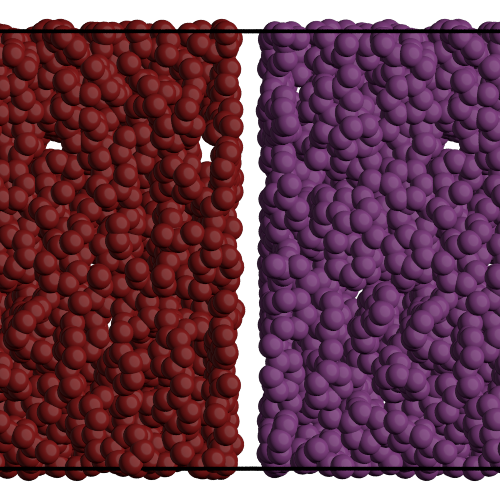

In [8]:
sim_viewer = FresnelGSD(gsd_file="weld.gsd", view_axis=(0, 1, 0), frame=0, height=12)
weld_colors = np.zeros_like(sim_viewer.positions)
weld_colors[:weld_colors.shape[0]//2 + 1] = np.array([0.5, 0.25, 0.5])
weld_colors[weld_colors.shape[0]//2 + 1:] = np.array([0.5, 0.1, 0.1])
sim_viewer.colors = weld_colors
sim_viewer.view(width=500, height=500)

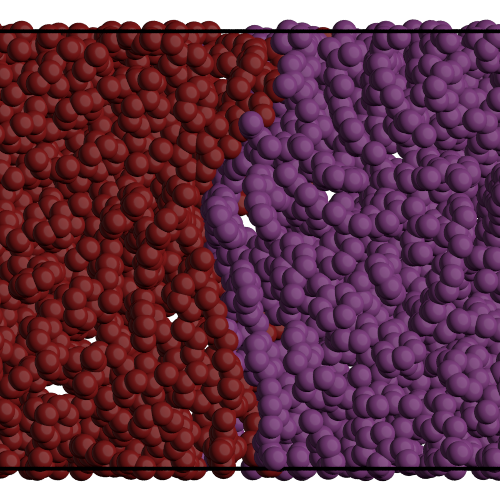

In [9]:
sim_viewer.frame = -1
sim_viewer.height = 12
sim_viewer.view_axis = (0, 1, 0)
sim_viewer.view(width=500, height=500)

In [12]:
# Running a tensile test simulation
from flowermd.library.simulations.tensile import Tensile
# Open and load the forcefield picke file
with open("forcefield.pickle", "rb") as f:
    hoomd_forces = pickle.load(f)
    
tensile_sim = Tensile(
    initial_state="pps-weld_restart.gsd",
    forcefield=hoomd_forces,
    tensile_axis=(1,0,0),
    gsd_file_name="pps-tensile.gsd",
    gsd_write_freq=1000,
    log_file_name="pps-tensile_log.txt",
    log_write_freq=500,
    fix_ratio=0.30,
    device = cpu
)
tensile_sim.run_tensile(n_steps=1e5, strain=0.50, period=500, kT=2.0, tau_kt=0.001)
tensile_sim.flush_writers()

Initializing simulation state from a GSD file.
Step 0 of 100001; TPS: 0.0; ETA: nan hours, nan minutes
Step 750 of 100001; TPS: 120.7; ETA: 13.7 minutes
Step 1500 of 100001; TPS: 122.93; ETA: 13.4 minutes
Step 2250 of 100001; TPS: 125.55; ETA: 13.0 minutes
Step 3000 of 100001; TPS: 123.98; ETA: 13.0 minutes
Step 3750 of 100001; TPS: 124.8; ETA: 12.9 minutes
Step 4500 of 100001; TPS: 124.64; ETA: 12.8 minutes
Step 5250 of 100001; TPS: 124.84; ETA: 12.6 minutes
Step 6000 of 100001; TPS: 124.56; ETA: 12.6 minutes
Step 6750 of 100001; TPS: 124.55; ETA: 12.5 minutes
Step 7500 of 100001; TPS: 124.17; ETA: 12.4 minutes
Step 8250 of 100001; TPS: 124.06; ETA: 12.3 minutes
Step 9000 of 100001; TPS: 124.16; ETA: 12.2 minutes
Step 9750 of 100001; TPS: 124.2; ETA: 12.1 minutes
Step 10500 of 100001; TPS: 124.08; ETA: 12.0 minutes
Step 11250 of 100001; TPS: 124.1; ETA: 11.9 minutes
Step 12000 of 100001; TPS: 124.03; ETA: 11.8 minutes
Step 12750 of 100001; TPS: 123.79; ETA: 11.7 minutes
Step 13500 of 

In [ ]:
sim_viewer2 = FresnelGSD(gsd_file="pps-tensile.gsd", view_axis=(0, 1, 0), frame=99, height=12)
weld_colors = np.zeros_like(sim_viewer2.positions)
weld_colors[:weld_colors.shape[0]//2 + 1] = np.array([0.5, 0.25, 0.5])
weld_colors[weld_colors.shape[0]//2 + 1:] = np.array([0.5, 0.1, 0.1])
sim_viewer2.colors = weld_colors
sim_viewer2.view(width=500, height=500)